In [11]:
"""
Goal: Develop a line search algorithm using:
                - steepest descent
                - quasi Newton Method

Validation: Use the following test cases from the book:
                -  D.1.1 (a quadratic function)
                -  D.1.2 (Rosenbrock)
                -  D.1.3 (The bean function we’ve been exploring)
"""

import numpy as np
import matplotlib.pyplot as plt

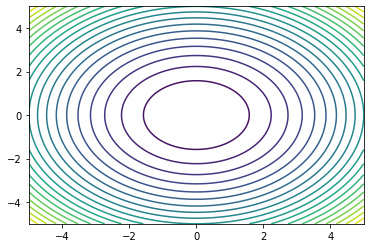

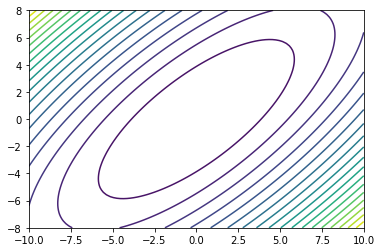

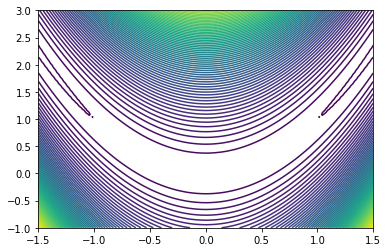

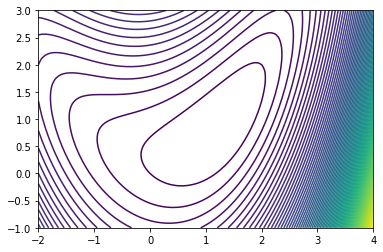

In [27]:
# Validation Functions
# der=0 just return the function value
# der=1 just return the derivative
# der=2 return function value and derivative

def f_simple(x):
    # Global minimum: 0.0 at (0,0)
    return x[0]**2 + x[1]**2
def fd_simple(x):
    return np.array([2*x[0], 2*x[1]]).reshape([-1,1])


def f_quadratic(x):
    # Global minimum: 0.0 at (0,0)
    beta = 3/2
    return x[0]**2 + x[1]**2 - beta*x[0]*x[1]
def fd_quadratic(x):
    beta = 3/2
    return np.array([2*x[0] - beta*x[1], 2*x[1]-beta*x[0]]).reshape([-1,1])


def f_rosenbrock(x):
    # Global minimum: 0.0 at (1,1)
    return (1-x[0]**2) + 100*(x[1] - x[0]**2)**2
def fd_rosenbrock(x):
    return np.array([2*(x[0] - 1) - 400*x[0]*(x[1]-x[0]**2), 200*(x[1]-x[0]**2)]).reshape([-1,1])

def f_bean(x):
    # Global Minimum: 0.09194 at x = (1.21314, 0.82414)
    return (1-x[0])**2 + (1-x[1])**2 + 0.5*(2*x[1] - x[0]**2)**2
def fd_bean(x):
    return np.array([2*(x[0] - 1) - 2*(2*x[1] - x[0]**2)*x[0], 2*(x[1] - 1) + 2*(2*x[1] - x[0]**2)])

def plot_function(f, x0, xf, zoom=100, res=None):
    n1 = 100
    n2 = 99
    x1 = np.linspace(x0[0], xf[0], n1)
    x2 = np.linspace(x0[1], xf[1], n2)

    fun = np.zeros([n1,n2])

    # function evaluations for the contour plot
    for i in range(n1):
        for j in range(n2):
            fun[i,j] = f([x1[i],x2[j]]) 

    # plotting
    plt.figure()
    plt.contour(x1, x2, np.transpose(fun), zoom)
    if res != None:
        plt.plot(res.x[0],res.x[1],'r*')
    plt.show()

plot_function(f_simple, (-5, -5), (5, 5), 20)
plot_function(f_quadratic, (-10, -8), (10, 8), 20)
plot_function(f_rosenbrock, (-1.5, -1), (1.5, 3), 100)
plot_function(f_bean, (-2, -1), (4, 3), 100)

In [ ]:
"""
Line Search Algorithm
    Inputs: 
        - x_k: value of x that is being used to evaluate the objective function
        - f: f(x_k + alpha*p_k) = phi(alpha) where f is the objective function
        - grad: grad(x_k + alpha*p_k).T @ p_k where grad is the derivative of the objective function
        - alpha_init (> 0): initial step size
        - mu_1 (0 < mu_1 < 1): sufficient decrease factor
        - mu_2 (mu_1 < mu_2 < 1): sufficient curvature factor
        - sigma (sigma > 1): step size increase factor
    Outputs:
        - alpha_star: acceptable step size (satisfies the strong Wolfe conditions)
"""

def bracket_line_search(x_k, f, grad, alpha_init, p_k, mu_1=1e-4, mu_2=0.75, sigma=2):
    # Define the initial bracket
    a1 = 0
    a2 = alpha_init

    # Used in pinpoint
    phi0 = f(x_k + alpha_init*p_k)
    phid0 = (grad(x_k + alpha_init*p_k).T @ p_k).item(0)
    phi1 = phi0
    phid1 = phid0
    first = True

    while True:
        phi2 = f(x_k + a2*p_k)
        if (phi2 > (phi0 + mu_1*a2*phid0)) or (not first and phi2 > phi1):
            return pinpoint(a1, a2, p_k, x_k, f, grad, phi0, phid0, mu_1, mu_2) # 1 is lower and 2 is higher

        phid2 = grad(x_k + a2*p_k).T @ p_k
        if np.abs(phid2) <= -mu_2*phid0:
            return a2
        elif phid2 >= 0:
            return pinpoint(a2, a1, p_k, x_k, f, grad, phi0, phid0, mu_1, mu_2) # 2 is lower and 1 is higher 
        else:
            a1 = a2
            a2 *= sigma
        first = False
# ==========================================================================================================

"""
Pinpoint function for line search Algorithm
    Inputs: 
        - alpha_low: interval endpoint with lower function value
        - alpha_high: interval endpoint with higher function value
        - f: f(x_k + alpha*p_k) = phi(alpha) where f is the objective function
        - grad: grad(x_k + alpha*p_k).T @ p_k where grad is the derivative of the objective function
        
        - phi_low: function value at alpha_low
        - phi_high: function value at alpha_high
        - phi_0, phi_d0: computed in outer routine, pass in to save function call
        - mu_1 (0 < mu_1 < 1): sufficient decrease factor
        - mu_2 (mu_1 < mu_2 < 1): sufficient curvature factor
    Outputs:
        - alpha_star: step size satisfying the strong Wolfe conditions
"""
def pinpoint(alpha_low, alpha_high, p_k, x_k, f, grad, phi_0, phi_d0, mu_1, mu_2):
    k = 0
    phi_low = f(x_k + alpha_low*p_k)
    phi_dlow = grad(x_k + alpha_low*p_k).T @ p_k
    phi_high = f(x_k + alpha_high*p_k)
    phi_dhigh = grad(x_k + alpha_high*p_k).T @ p_k

    while True:
        alpha_p = interpolate(alpha_low, alpha_high, phi_low, phi_high, phi_dlow, phi_dhigh).item(0)
        phi_p = f(x_k + alpha_p*p_k)
        phi_dp = grad(x_k + alpha_p*p_k).T @ p_k
        if (phi_p > phi_0 + mu_1*alpha_p*phi_d0) or (phi_p > phi_low):
            alpha_high = alpha_p
        else:
            if np.abs(phi_dp) <= -mu_2*phi_d0:
                return alpha_p
            elif phi_dp*(alpha_high - alpha_low) >= 0:
                alpha_high = alpha_low
            alpha_low = alpha_p
        k += 1
# ==========================================================================================================

"""
interpolate is a helper for the pinpoint function to find a better point within the interval
"""
def interpolate(alpha_1, alpha_2, phi_1, phi_2, phi_d1, phi_d2):
    beta_1 = phi_d1 + phi_d2 - 3 * (phi_1 - phi_2) / (alpha_1 - alpha_2)
    beta_2 = np.sign(alpha_2 - alpha_1) * np.sqrt(beta_1**2 - phi_d1*phi_d2)

    alpha_star = alpha_2 - (alpha_2 - alpha_1) * (phi_d2 + beta_2 - beta_1) / (phi_d2 - phi_d1 + 2*beta_2)
    return alpha_star

In [ ]:
"""
Steepest Descent Search Direction
    Inputs: 
        - f: function to be minimized
        - grad: derivative of the function to be minimized
        - x0: starting point
        - tau: convergence tolerance
    Outputs:
        - x_star: optimal point
        - f_x_star: minimum function value
"""

def steepest_descent(f, grad, x0, tau=1e-6, max_iter=200, print_=True):
    k = 0
    x_k = x0
    df = grad(x_k)
    df_1 = df
    p_k1 = np.array([])

    while np.linalg.norm(df, ord=np.Inf) > tau and k < max_iter:
        # get the step direction
        p_k = np.reshape((-df/np.linalg.norm(df)),(2,))
        
        # Find initial step size
        if p_k1.size == 0:
            alpha_init = 1
        else:
            alpha_init = alpha_k * (df_1.T @ p_k1) / (df.T @ p_k)

        alpha_k = bracket_line_search(x_k, f, grad, alpha_init, p_k)
        x_k = x_k + alpha_k*p_k # step in the new direction

        # For next iteration
        df_1 = df
        df = grad(x_k) # calculate derivative to be able to have only one function call
        p_k1 = p_k
        k += 1

    if print_:
        print(f'Optimization finished in {k} iterations. \nx* = {x_k} \nf(x*) = {f(x_k)}\nStopping Condition: {np.linalg.norm(df, ord=np.Inf)}\n')
    return x_k, f(x_k)

# Test Steepest Descent
# x_k, f_value = steepest_descent(f_simple, fd_simple, np.array([4, 3]))
x_k, f_value = steepest_descent(f_quadratic, fd_quadratic, np.array([8, 5]))
# x_k, f_value = steepest_descent(f_rosenbrock, fd_rosenbrock, np.array([4, 3]))
# x_k, f_value = steepest_descent(f_bean, fd_bean, np.array([4, 3]))



In [15]:
"""
quasi Newton Search Direction
    Inputs: 
        - 
        - 
    Outputs:
        - 
        - 
        
"""

'\nquasi Newton Search Direction\n    Inputs: \n        - \n        - \n    Outputs:\n        - \n        - \n        \n'